In [2]:
!pip install xgboost

  Using cached xgboost-3.0.4-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.4-py3-none-win_amd64.whl (56.8 MB)


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)
import joblib

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [6]:
os.chdir('..')  

In [7]:
# Load processed data
X_train = pd.read_csv('data/processed/X_train_scaled.csv')
X_test = pd.read_csv('data/processed/X_test_scaled.csv')
y_train = pd.read_csv('data/processed/y_train.csv').values.ravel()  # Convert to 1D
y_test = pd.read_csv('data/processed/y_test.csv').values.ravel()

In [9]:
# Train
lr = LogisticRegression(random_state=42, max_iter=1000)
lr.fit(X_train, y_train)

# Predict
y_pred_lr = lr.predict(X_test)
y_prob_lr = lr.predict_proba(X_test)[:, 1]

# Evaluate
print("✅ Logistic Regression")
print(f"AUC: {roc_auc_score(y_test, y_prob_lr):.3f}")
print(classification_report(y_test, y_pred_lr))

✅ Logistic Regression
AUC: 0.845
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.67      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409



In [10]:
# Train
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluate
print("✅ Random Forest")
print(f"AUC: {roc_auc_score(y_test, y_prob_rf):.3f}")
print(classification_report(y_test, y_pred_rf))

✅ Random Forest
AUC: 0.822
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1035
           1       0.62      0.48      0.54       374

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.77      1409



In [11]:
# Estimate scale_pos_weight
ratio = len(y_train[y_train==0]) / len(y_train[y_train==1])
print(f"Class ratio (No:Yes): {ratio:.2f}")

# Train XGBoost
xgb = XGBClassifier(
    random_state=42,
    scale_pos_weight=ratio,  # Tell model: "Negatives are more common"
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# Evaluate
print("✅ XGBoost")
print(f"AUC: {roc_auc_score(y_test, y_prob_xgb):.3f}")
print(classification_report(y_test, y_pred_xgb))

Class ratio (No:Yes): 2.77
✅ XGBoost
AUC: 0.822
              precision    recall  f1-score   support

           0       0.87      0.79      0.83      1035
           1       0.54      0.67      0.60       374

    accuracy                           0.76      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.78      0.76      0.77      1409



C:\Users\hp\AppData\Local\Temp\ipykernel_10156\3967818140.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=auc_scores, y=models, palette='Blues_r')


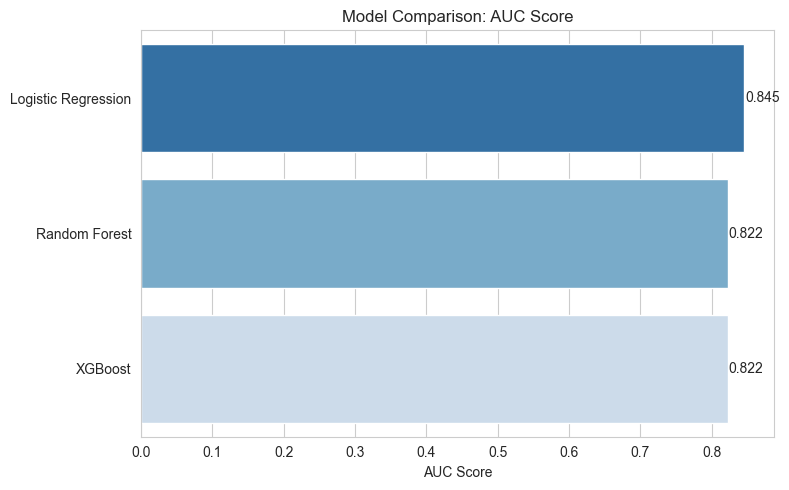

In [12]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
auc_scores = [
    roc_auc_score(y_test, y_prob_lr),
    roc_auc_score(y_test, y_prob_rf),
    roc_auc_score(y_test, y_prob_xgb)
]

# Plot AUC comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=auc_scores, y=models, palette='Blues_r')
plt.title('Model Comparison: AUC Score')
plt.xlabel('AUC Score')
for i, v in enumerate(auc_scores):
    plt.text(v + 0.001, i, f'{v:.3f}', va='center')
plt.tight_layout()
plt.savefig('reports/images/model_auc_comparison.png', bbox_inches='tight')
plt.show()

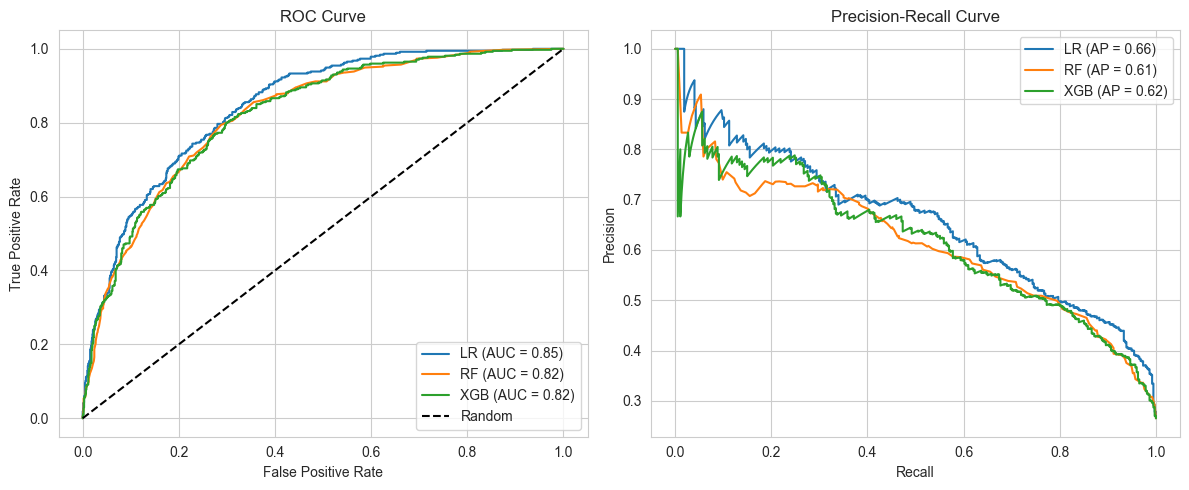

In [13]:
# ROC Curve
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)

plt.plot(fpr_lr, tpr_lr, label=f'LR (AUC = {auc_scores[0]:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC = {auc_scores[1]:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGB (AUC = {auc_scores[2]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 2, 2)
ap_lr = average_precision_score(y_test, y_prob_lr)
ap_rf = average_precision_score(y_test, y_prob_rf)
ap_xgb = average_precision_score(y_test, y_prob_xgb)

prec_lr, rec_lr, _ = precision_recall_curve(y_test, y_prob_lr)
prec_rf, rec_rf, _ = precision_recall_curve(y_test, y_prob_rf)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)

plt.plot(rec_lr, prec_lr, label=f'LR (AP = {ap_lr:.2f})')
plt.plot(rec_rf, prec_rf, label=f'RF (AP = {ap_rf:.2f})')
plt.plot(rec_xgb, prec_xgb, label=f'XGB (AP = {ap_xgb:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

plt.tight_layout()
plt.savefig('reports/images/roc_pr_curves.png', bbox_inches='tight')
plt.show()

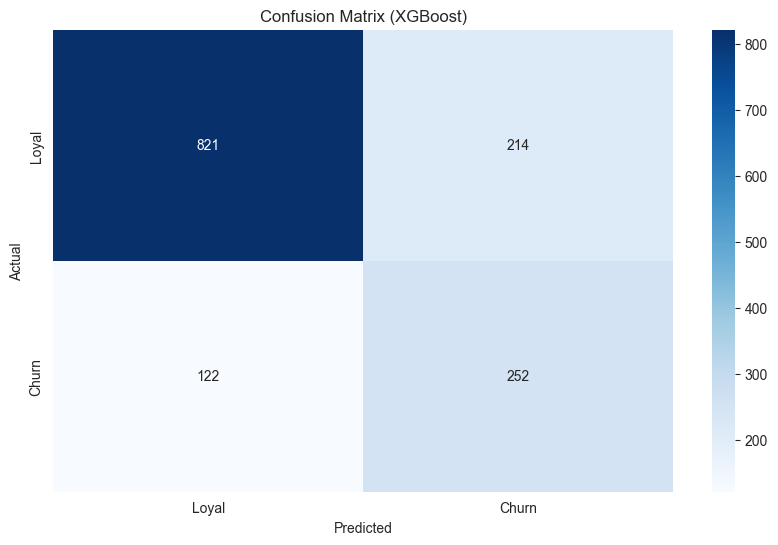

In [14]:
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Loyal', 'Churn'], yticklabels=['Loyal', 'Churn'])
plt.title('Confusion Matrix (XGBoost)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.savefig('reports/images/confusion_matrix.png', bbox_inches='tight')
plt.show()

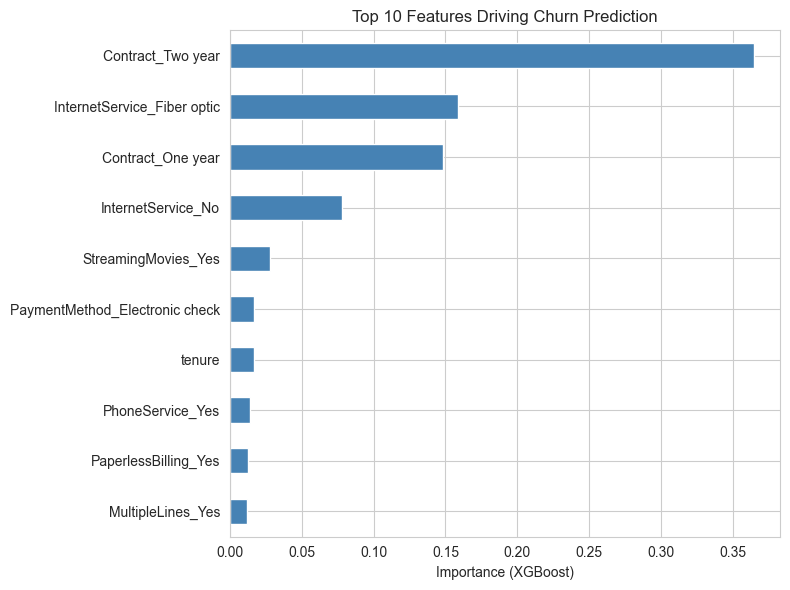

In [15]:
importances = xgb.feature_importances_
feature_names = X_train.columns
feat_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Top 10
plt.figure(figsize=(8, 6))
feat_importance.head(10).plot(kind='barh', color='steelblue')
plt.title('Top 10 Features Driving Churn Prediction')
plt.xlabel('Importance (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('reports/images/feature_importance.png', bbox_inches='tight')
plt.show()

In [16]:
# Save XGBoost model
joblib.dump(xgb, 'models/churn_model.pkl')

# Also save the label encoder if you had one (we didn’t need it)
# joblib.dump(scaler, 'models/scaler.pkl')  # Already saved

print("✅ Model saved to models/churn_model.pkl")

✅ Model saved to models/churn_model.pkl
